In [1]:
RANDOM_STATE = 42

In [25]:
import numpy as np
import pandas as pd
import pickle
from sklearn.impute import SimpleImputer

def prepare_related_data(columns: list, index_column: str, df: pd.DataFrame) -> pd.DataFrame:
    """
    Related data will be processed in the same way:
    - group by `index_column`
    - sum all columns
    - apply log1p to all columns except `index_column`
    """
    col_to_fetch = columns + [index_column]
    res = df[col_to_fetch].groupby(index_column).sum()
    res = res[columns].apply(np.log1p)
    return res


def prepare_data(train: pd.DataFrame, dpi: pd.DataFrame, bnum: pd.DataFrame) -> pd.DataFrame:
    """
    Prepare data for training
    """
    dpi_columns = ['SUM_of_Duration_sec','SUM_of_Volume_kb','SUM_of_Count_events','MAX_of_day_cnt']
    dpi_index_column = 'abon_id'

    bnum_columns = ['call_cnt_out','call_cnt_in','call_dur_out','call_dur_in','cnt_sms_out','cnt_sms_in']
    bnum_index_column = 'abon_id'

    df_train_dpi_agg = prepare_related_data(dpi_columns, dpi_index_column, dpi)
    df_train_bnum_agg = prepare_related_data(bnum_columns, bnum_index_column, bnum)
    # let's merge all dataframes
    # merge bnum dataframe
    df_train = train.merge(df_train_bnum_agg, on='abon_id', how='left')

    # merge dpi dataframe
    df_train = df_train.merge(df_train_dpi_agg, on='abon_id', how='left')

    # fill missings for dpi_columns, bnum_columns
    df_train.fillna({col: df_train[col].median() for col in dpi_columns + bnum_columns}, inplace=True)
    return df_train

def drop_columns_with_nulls(frame: pd.DataFrame, threshold: float = 0.7) -> pd.DataFrame:
    """
    Drop columns with more than threshold % of nulls
    """
    return frame.dropna(thresh=threshold*frame.shape[0], axis=1)


def impute_dataset(X, y) -> pd.DataFrame:
    """
    Impute dataset
    """
    simple_impute = SimpleImputer(missing_values=np.nan, add_indicator=True, strategy='constant', fill_value=0)
    imputed = simple_impute.fit_transform(X, y)
    # Extract the indicator columns
    indicator = simple_impute.indicator_
    indicator_columns = indicator.get_feature_names_out(input_features=X.columns)
    # Reconstruct the DataFrame with the original columns and indicator columns
    new_columns = list(X.columns) + list(indicator_columns)
    return pd.DataFrame(imputed, columns=new_columns, index=X.index)


def scale_features(X: pd.DataFrame) -> pd.DataFrame:
    """
    Scale features
    """
    # return X
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    return pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)


def prepare_dataset(train: pd.DataFrame, dpi: pd.DataFrame, bnum: pd.DataFrame, features: list[str] | None = None) -> tuple[pd.DataFrame, pd.Series]:
    """
    Prepare dataset for training
    """
    dataset = prepare_data(train, dpi, bnum)
    if features:
        # if features are provided, we will use only them
        X, y = dataset.drop('target', axis=1), dataset['target']
        X = impute_dataset(X, y)
        X = X[features]
        X = scale_features(X[features])
        return X, y
    else:
        df_train_nulls_removed = drop_columns_with_nulls(dataset)
        X, y = df_train_nulls_removed.drop('target', axis=1), df_train_nulls_removed['target']
        X = impute_dataset(X, y)
        X = scale_features(X)
        return X, y


def prepare_dataset_short(train: pd.DataFrame, dpi: pd.DataFrame, bnum: pd.DataFrame, features: list[str] | None = None, columns_to_drop: list[str] | None = None) -> tuple[pd.DataFrame, pd.Series]:
    """
    Prepare dataset for training
    """
    dataset = prepare_data(train, dpi, bnum)

    # drop columns
    dataset =  dataset.drop(columns=columns_to_drop) if columns_to_drop else dataset
    if features:
        # if features are provided, we will use only them
        X, y = dataset.drop('target', axis=1), dataset['target']
        X = impute_dataset(X, y)
        X = X[features]

#         pca = PCA(n_components=2)
#         pca_result = pca.fit_transform(scaled_data)
        return X, y
    else:
        df_train_nulls_removed = drop_columns_with_nulls(dataset)
        X, y = df_train_nulls_removed.drop('target', axis=1), df_train_nulls_removed['target']
        X = impute_dataset(X, y)

#         X_scaled = scale_features(X_imputed)
#         pca = PCA(n_components=2)
#         pca_result = pca.fit_transform(scaled_data)
        return X, y


## MODEL ESTIMATION

# MAke predictions
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import matplotlib.pyplot as plt

def evaluate_model(model, X: pd.DataFrame, y: pd.Series, threshold: float = 0.5) -> None:
    """
    Evaluate model
    """
    preds_proba = model.predict_proba(X)[:, 1]
    
    # Use the specified threshold
    preds = (preds_proba >= threshold).astype(int)
    
    # Print evaluation metrics
    print(f'Accuracy: {accuracy_score(y, preds)}')
    print(f'F1: {f1_score(y, preds)}')
    print(f'Precision: {precision_score(y, preds)}')
    print(f'Recall: {recall_score(y, preds)}')
    print(f'ROC AUC: {roc_auc_score(y, preds)}')
    
    auc_score = roc_auc_score(y, preds_proba)
    cm = confusion_matrix(y, preds, labels=model.classes_)
    print(f'AUC: {auc_score}')
    print(f'Classification Report: {classification_report(y, preds, target_names=["not churn", "churn"])}')

    # Get ROC curve data
    fpr, tpr, thresholds = roc_curve(y, preds_proba)
    with plt.style.context('dark_background'):
        pass
        # Plot ROC curve
        plt.figure()
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc_score:.3f})')
        plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model.__class__.__name__}')
        plt.legend(loc="lower right")
        plt.show()
        
        # Plot confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
        disp.plot()
        plt.show()


In [15]:

with open(r'../Data/churn_model_pd2.pcl', 'rb') as f:
    bdl_data = pickle.load(f)
gen_info, train_data, test_data = bdl_data
train_info, df_train_fe, df_train_bnum, df_train_dpi = train_data
test_info, df_test_fe, df_test_bnum, df_test_dpi = test_data


In [4]:
# open trained_models.joblib
from joblib import load

cbc = load('Model/cbc.joblib')
lgbmc = load('Model/lgbmc.joblib')
ensemble = load('Model/ensemble_full.joblib')
lgbmc_50 = load('Model/lgbmc_50.pkl')
lgbmc_full = load('Model/lgbmc_full.pkl')
ensemble_50 = load('Model/ensemble_50.pkl')

/Users/andriigerasymchuk/private-repositories/ml-projects/venv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.2.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/andriigerasymchuk/private-repositories/ml-projects/venv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator VotingClassifier from version 1.2.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [5]:
# prepare a test dataset
X_test, y_test = prepare_dataset(df_test_fe, df_test_dpi, df_test_bnum, features=lgbmc.feature_name_)

Accuracy: 0.8889733333333333
F1: 0.4508704827222369
Precision: 0.3267383512544803
Recall: 0.7271083696692545
ROC AUC: 0.8134535425734126
AUC: 0.8978990549718945
Classification Report:               precision    recall  f1-score   support

   not churn       0.98      0.90      0.94    140597
       churn       0.33      0.73      0.45      9403

    accuracy                           0.89    150000
   macro avg       0.65      0.81      0.69    150000
weighted avg       0.94      0.89      0.91    150000



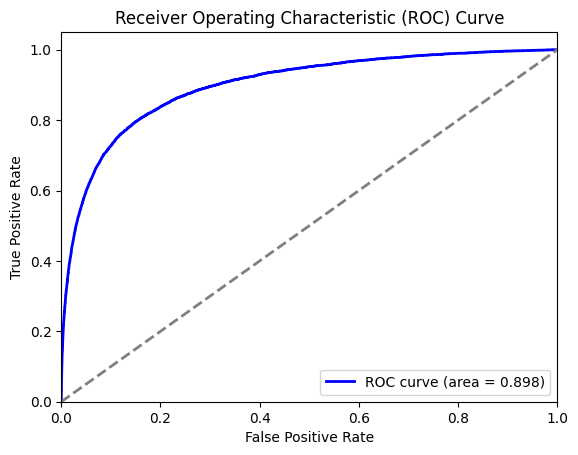

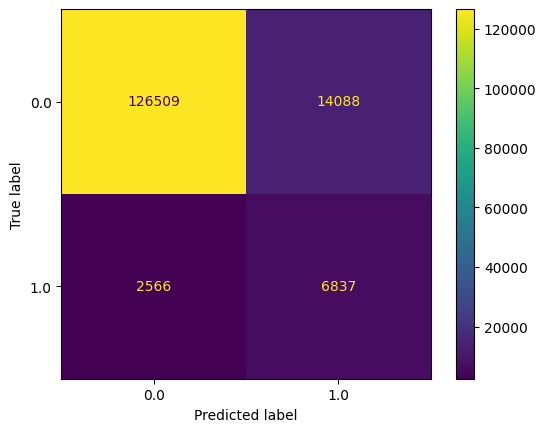

In [8]:
evaluate_model(ensemble, X_test, y_test)

In [7]:
X_test_short, y_test_short = prepare_dataset_short(df_test_fe, df_test_dpi, df_test_bnum, features=lgbmc_full.feature_name_)

Accuracy: 0.85666
F1: 0.40432192824490926
Precision: 0.27337779109845645
Recall: 0.7760289269382112
ROC AUC: 0.8190407300324035
AUC: 0.8951227991150188
Classification Report:               precision    recall  f1-score   support

   not churn       0.98      0.86      0.92    140597
       churn       0.27      0.78      0.40      9403

    accuracy                           0.86    150000
   macro avg       0.63      0.82      0.66    150000
weighted avg       0.94      0.86      0.89    150000



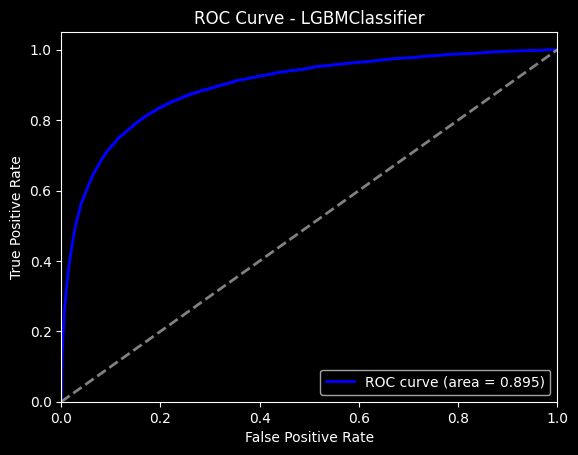

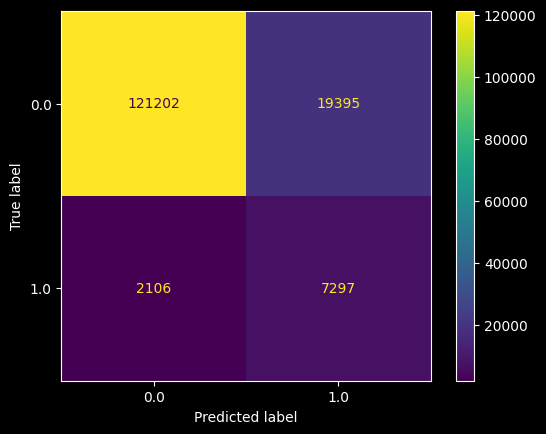

In [27]:
evaluate_model(lgbmc_50, X_test_short[lgbmc_50.feature_name_], y_test_short)

Accuracy: 0.9446466666666666
F1: 0.5140750277989115
Precision: 0.5715773034877668
Recall: 0.46708497288099543
ROC AUC: 0.7218352665140412
AUC: 0.8969865380674733
Classification Report:               precision    recall  f1-score   support

   not churn       0.96      0.98      0.97    140597
       churn       0.57      0.47      0.51      9403

    accuracy                           0.94    150000
   macro avg       0.77      0.72      0.74    150000
weighted avg       0.94      0.94      0.94    150000



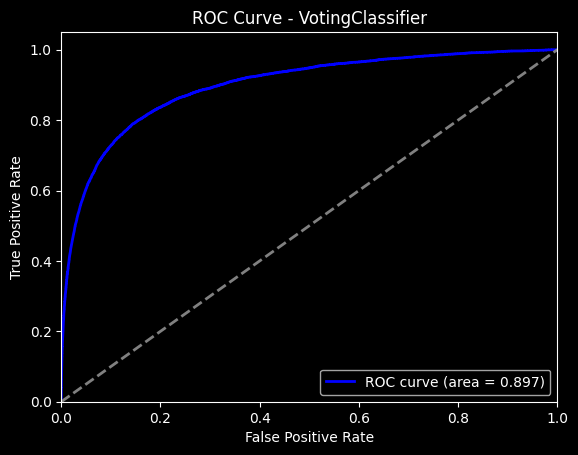

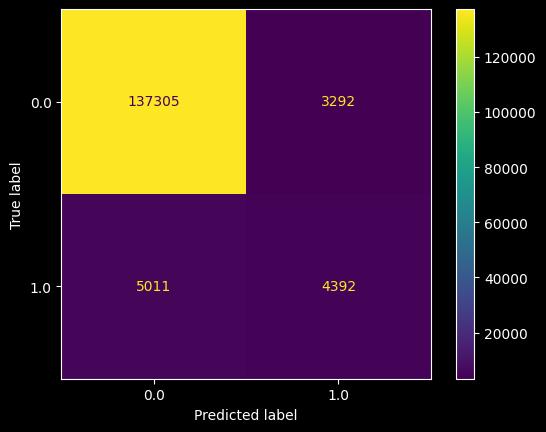

In [26]:

evaluate_model(ensemble_50, X_test_short[lgbmc_50.feature_name_], y_test_short)